In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as an
import scipy
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import gget
import scanpy.external as sce
import math
import time
from itertools import combinations
from itertools import chain
from mpl_toolkits.axes_grid1 import make_axes_locatable

sc.settings.verbosity = 3  

import utils as ut
import plotting as plt2

In [2]:
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
pang = ut.load_pathway(fpath)  
pang.head()

label,Acinar Cells,Adipocyte Progenitor Cells,Adipocytes,Adrenergic Neurons,Airway Epithelial Cells,Airway Goblet Cells,Airway Smooth Muscle Cells,Alpha Cells,Alveolar Macrophages,Anterior Pituitary Gland Cells,...,Transient Cells,Trichocytes,Trigeminal Neurons,Trophoblast Cells,Trophoblast Progenitor Cells,Trophoblast Stem Cells,Tuft Cells,Undefined Placental Cells,Urothelial Cells,Vascular Smooth Muscle Cells
GDF15,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
RARRES2,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TM4SF4,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
CELA1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
GCG,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/merged_scfib.h5ad"
adata = sc.read_h5ad(fpath)
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]
sc.logging.print_memory_usage()
adata

Memory usage: current 7.92 GB, difference +7.92 GB


AnnData object with n_obs × n_vars = 16130 × 13579
    obs: 'cluster_str', 'dataset', 'pred_phase', 'leiden', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'new_cluster', 'UMAP 1', 'UMAP 2'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cluster_str_colors', 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'pca', 'pred_phase_colors', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    layers: 'combat', 'counts', 'log_norm', 'magic', 'norm'
    obsp: 'connectivities', 'distances'

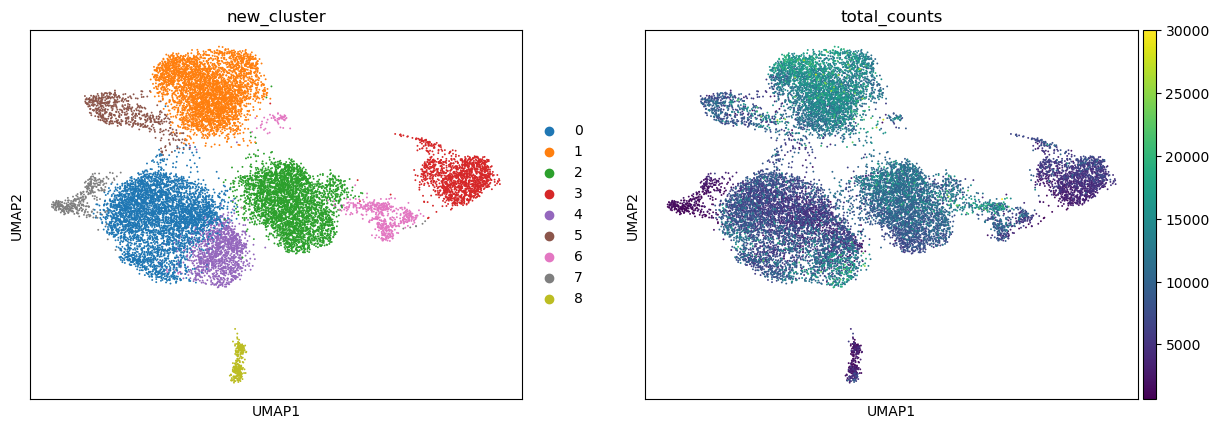

In [4]:
sc.pl.umap(
    adata,
    color=[
        'new_cluster', 
        'total_counts',
    ],
    ncols=2,
)

In [5]:
adata

AnnData object with n_obs × n_vars = 16130 × 13579
    obs: 'cluster_str', 'dataset', 'pred_phase', 'leiden', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'new_cluster', 'UMAP 1', 'UMAP 2'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cluster_str_colors', 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'pca', 'pred_phase_colors', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    layers: 'combat', 'counts', 'log_norm', 'magic', 'norm'
    obsp: 'connectivities', 'distances'

# PCA Centroid Distance

In [6]:
result = []

for cluster in sorted(adata.obs['new_cluster'].unique()):    
    X = adata[adata.obs['new_cluster'] == cluster, :].obsm['X_pca'].copy()
    centroid = X.mean(axis=0)
    centroid = pd.DataFrame({ 
        f"F{int(cluster)+1}" : centroid
    })
    
    result.append(centroid)
    
result = pd.concat(result, axis=1)
print(f"{result.shape=}")
result = result.T

result.head()    

result.shape=(50, 9)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
F1,-1.867832,-2.635570,1.101460,0.312871,-0.099646,0.005630,-0.380251,-0.360347,-0.067563,0.113293,...,-0.035941,-0.028957,0.035231,-0.024684,-0.032308,-0.052169,0.002144,-0.051848,0.016476,0.012827
F2,-2.640345,3.891366,-0.222813,-0.250486,0.490173,-0.036584,-0.096242,-0.269532,-0.130224,-0.035175,...,-0.026031,-0.008961,-0.015883,0.023243,0.010957,-0.009674,-0.009098,-0.054400,-0.003363,0.007922
F3,2.702904,-2.420286,-0.547800,-0.261461,0.704272,-0.484798,-0.027813,0.141558,-0.045962,-0.161655,...,0.012465,0.006294,-0.009435,0.012291,0.016813,0.031818,0.008777,0.045243,-0.015103,-0.050820
F4,9.467586,3.985368,0.101765,0.906598,-1.173345,0.276750,-0.497367,-0.189866,0.533052,-0.013731,...,0.057845,0.003062,0.003963,-0.058047,0.050289,-0.015463,-0.008596,-0.040684,0.024144,0.058133
F5,-1.522006,-2.441800,-2.808383,-0.166069,0.128987,-0.295909,0.663987,0.628114,0.317909,-0.299303,...,0.038220,0.023854,-0.003364,0.014815,-0.053550,-0.014595,-0.047511,0.059794,0.010972,-0.003492


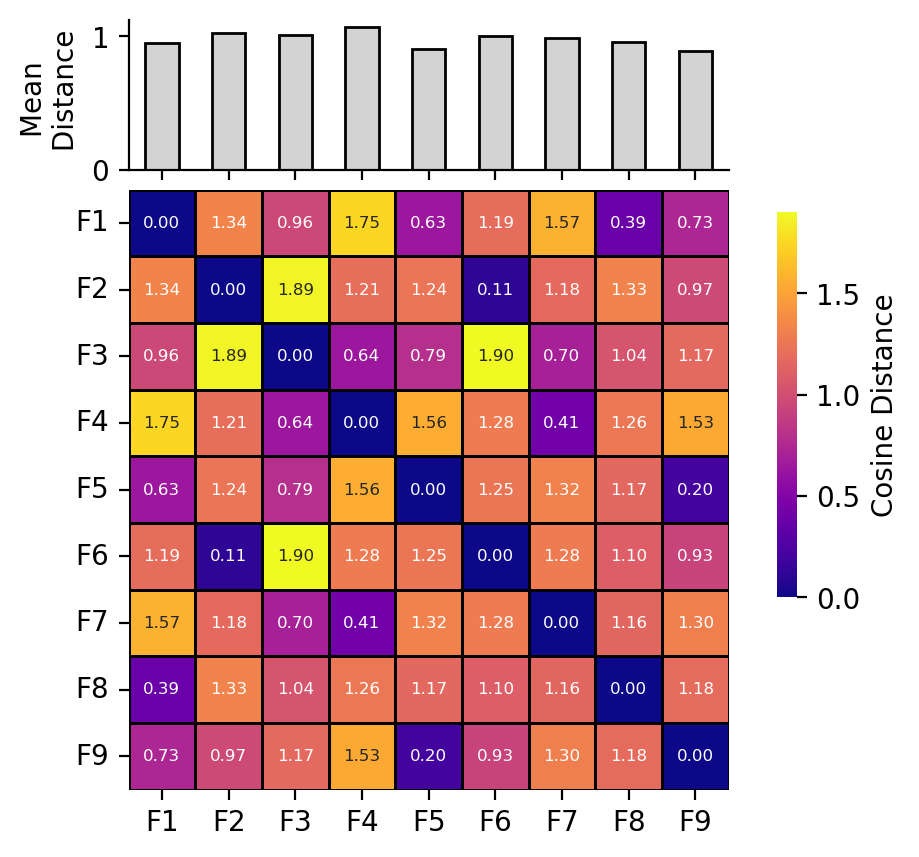

In [7]:
metric = 'cosine'

A = pd.DataFrame(
    squareform(pdist(result, metric=metric)), 
    index=result.index, 
    columns=result.index,
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

ax = sns.heatmap(
    A,
    square=True,
    linecolor='k',
    lw=1,
    fmt=".2f",
    annot=True,
    annot_kws={'fontsize' : 6},
    cmap='plasma',
    cbar_kws={'shrink': 0.5, 'label' : f'{metric.title()} Distance'}
)

plt.ylabel("")
plt.xlabel("")

plt.gca().tick_params(axis='y', rotation=0)

# Create a divider for the axes
divider = make_axes_locatable(ax)
ax2 = divider.append_axes(
    "top", 
    size="25%",
    pad=0.1, 
    # sharex=ax,
)  # Adjust "size" and "pad" as needed

# Calculate column averages
col_averages = A.mean()

# Plot the bar chart
sns.barplot(
    x=col_averages.index, 
    y=col_averages.values, 
    color='lightgray',
    ec='k',
    width=0.5,
    ax=ax2,
)

ax2.set_xlabel("")
ax2.set_ylabel("Mean \n Distance")

ax2.tick_params(axis='x', labelsize=1, labelcolor='none')
sns.despine(ax=ax2)


# scanorama

computing neighbors
    finished: added to `.uns['scanorama_neighbors']`
    `.obsp['scanorama_neighbors_distances']`, distances for each pair of neighbors
    `.obsp['scanorama_neighbors_connectivities']`, weighted adjacency matrix (0:00:51)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


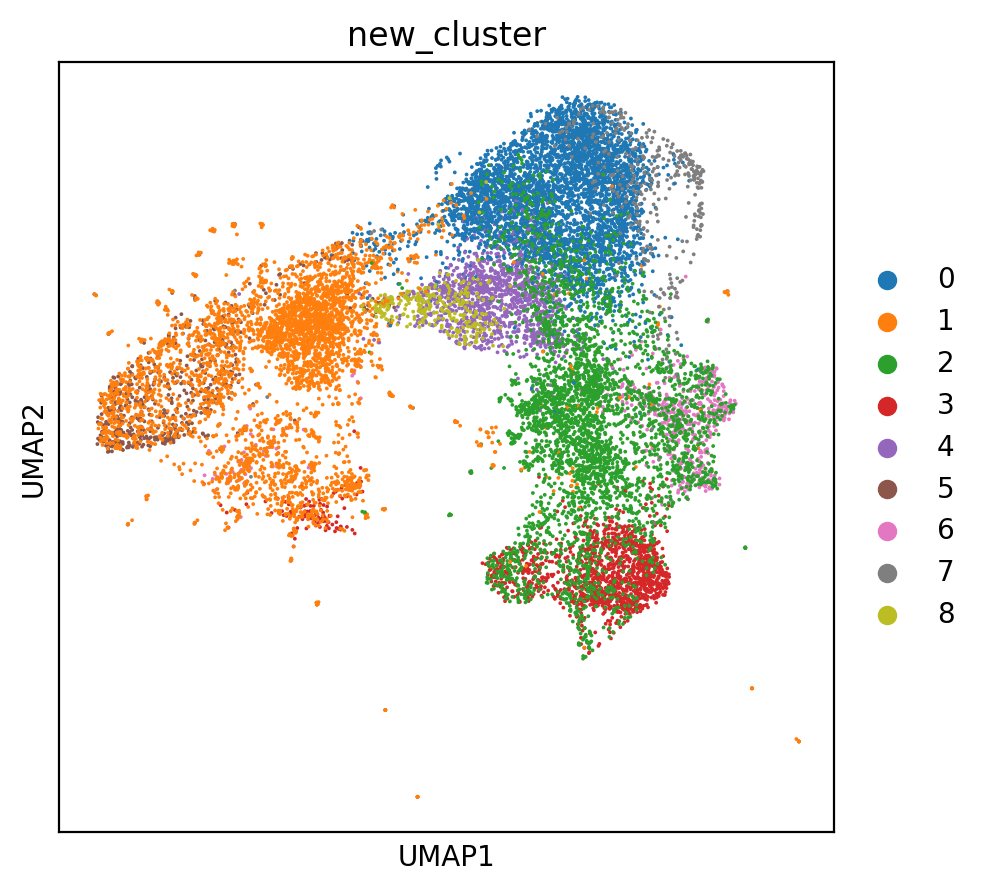

In [11]:
sc.pp.neighbors(
    adata,
    use_rep='X_scanorama',
    key_added='scanorama_neighbors',
)
    
sc.tl.umap(
    adata,
    neighbors_key='scanorama_neighbors'
)

sc.pl.umap(
    adata,
    color='new_cluster'
)

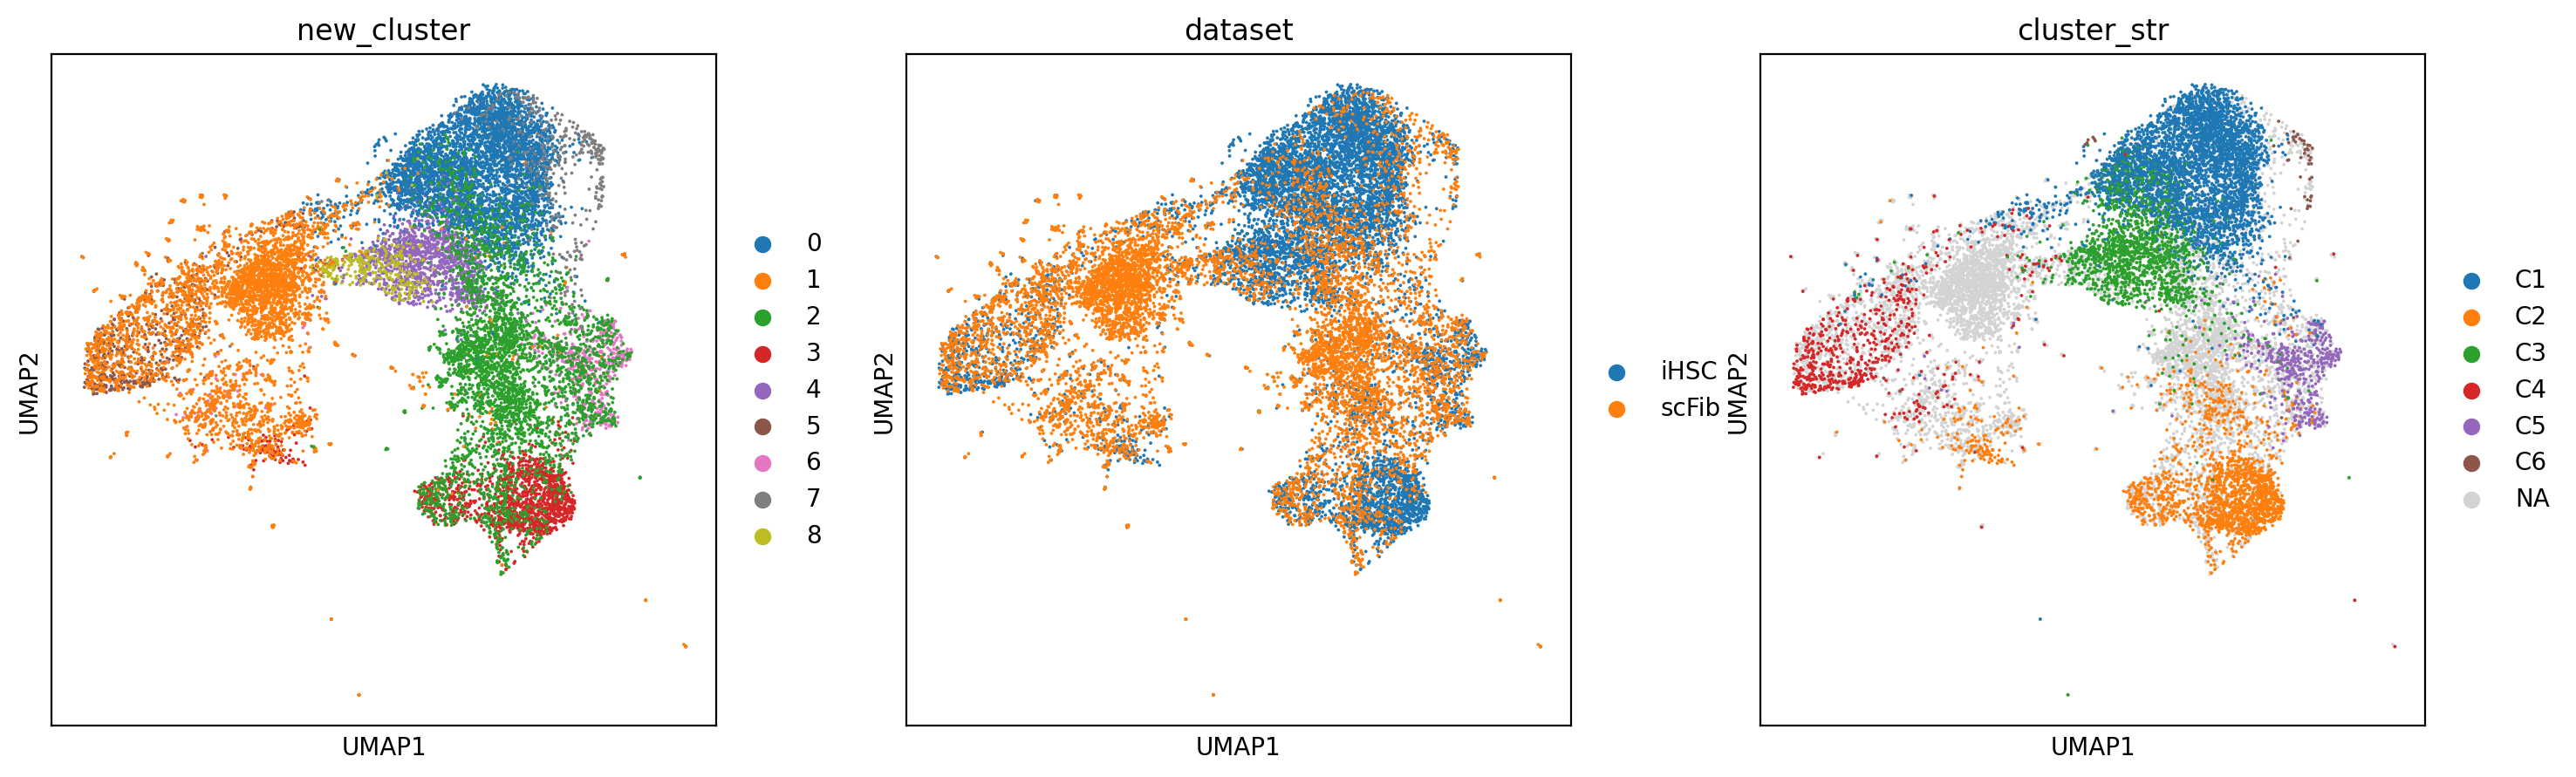

In [12]:

sc.pl.umap(
    adata,
    color=['new_cluster', 'dataset', 'cluster_str']
)

In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)